## Environment

In [159]:
import numpy as np

In [160]:
np.random.multinomial(1,[1/5.]*5)

array([0, 0, 0, 1, 0])

In [161]:
class Environment():

  def __init__(self, n_arms, probabilities, bids, average_number_of_clicks, average_cum_daily_cost,noise_clicks,noise_cost,change_frequency):
    self.n_arms = n_arms                                            # number of prices
    self.probabilities = probabilities                              # conversion rates for every price/arm
    self.average_number_of_clicks = average_number_of_clicks        # curve of average number of clicks (y = f(bids))
    self.average_cum_daily_cost = average_cum_daily_cost            # curve of cumulative daily cost (y = g(bids))
    self.noise_clicks = noise_clicks                                # gaussian noise for the average number of clicks sampling
    self.noise_cost = noise_cost                                    # gaussian noise for the cumulative daily cost sampling
    self.change_frequency = change_frequency                        # average freqeuency with which the phase changes
    self.i = np.argmax(np.random.multinomial(1,[1/5.]*5))                      # random phase inizialization
    self.bids = bids

  # daily rewards
  def bidding_round(self, pulled_bid):
    clicks = int(np.random.normal(self.average_number_of_clicks(self.bids[pulled_bid]),self.noise_clicks))        # number of people that click on the ad
    reward_click = clicks if clicks >= 0 else 0
    costs = np.random.normal(self.average_cum_daily_cost(self.bids[pulled_bid]),self.noise_cost)                  # cumulative daily cost
    reward_cost = costs if costs > 0 else 0

    return reward_click, reward_cost

  def pricing_round(self, pulled_price):
    reward_price = np.random.binomial(1,self.probabilities[self.i,pulled_price])                         # number of people that buy once they clicked
    if np.random.binomial(1, self.change_frequency):                                                     # phase change
      self.i = np.argmax(np.random.multinomial(1,[1/5.]*5))
    return reward_price

## Pricing

In [162]:
class Learner:
  def __init__(self,n_arms):
    self.n_arms = n_arms
    self.t = 0                                              # current round value
    self.rewards_per_arm = x = [[] for i in range(n_arms)]  # value of collected rewards for each round and for each arm
    self.collected_rewards = np.array([])                   # values of collected rewards for each round

  # function that updates the observation's list once the reward is returned by the environment
  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards,reward)

In [163]:
class Exp3_Pricing_Learner(Learner):
  def __init__(self,n_arms,prices, gamma=0.2):
    super().__init__(n_arms)                    # number of prices
    self.gamma = gamma  # parameters of beta distributions
    self.prices = prices                        # prices (array)
    self.weights = np.ones(len(prices))
    self.p = np.array([(1-self.gamma)*self.weights[i]/np.sum(self.weights)+self.gamma/len(self.prices) for i in range(len(self.prices))])

  def pull_arm(self):
    if(self.t < self.n_arms):
      return self.t
    self.p = np.array([(1-self.gamma)*self.weights[i]/np.sum(self.weights)+self.gamma/len(self.prices) for i in range(len(self.prices))])
    idx = np.random.choice([0,1,2,3,4], p=self.p)
    return idx

  # update parameters each time a reward in {0,1} is observed
  def update(self,pulled_arm, reward):
    self.t += 1
    self.update_observations(pulled_arm, reward#*self.prices[pulled_arm])
    est_reward = reward/self.p[pulled_arm]*self.prices[pulled_arm]
    self.weights[pulled_arm] = self.weights[pulled_arm]*np.exp(self.gamma*est_reward/len(self.prices))
    # if self.weights[pulled_arm]>10000:
    #   for w_idx in range(len(self.weights)):
    #     self.weights[w_idx] /= np.sum(self.weights)




## Simulation

In [164]:
import matplotlib.pyplot as plt
from tqdm import tqdm

In [165]:
# generic
T = 365                                # horizon of experiment
n_experiments = 100                    # since the reward functions are stochastic, to better visualize the results and remove the noise we do multiple experiments

In [166]:
# pricing
n_prices = 5
prices = [5,6,7,8,9]
p = np.array([[0.15,0.1,0.1,0.35,0.1],
              [0.25,0.05,0.15,0.45,0.05],
              [0.05,0.1,0.1,0.55,0.1],
              [0.35,0.2,0.4,0.05,0.05],
              [0.2,0.1,0.15,0.4,0.1]])           # bernoulli distributions for the reward functions

opt_rate = np.array([])
for i in range(p.shape[0]):
  opt = p[i,:][np.argmax(p[i,:]*prices)]
  opt_rate = np.append(opt_rate,opt)
  print("Phase " + str(i+1) + ":")
  print("idx: " + str(np.argmax(p[i,:]*prices)) + "  price: " + str(prices[np.argmax(p[i,:]*prices)]) + "  rate: " + str(opt) + "  price*rate: " + str(opt*prices[np.argmax(p[i,:]*prices)]))

Phase 1:
idx: 3  price: 8  rate: 0.35  price*rate: 2.8
Phase 2:
idx: 3  price: 8  rate: 0.45  price*rate: 3.6
Phase 3:
idx: 3  price: 8  rate: 0.55  price*rate: 4.4
Phase 4:
idx: 2  price: 7  rate: 0.4  price*rate: 2.8000000000000003
Phase 5:
idx: 3  price: 8  rate: 0.4  price*rate: 3.2


Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768
Advertising (optimal bid):
idx: 65  bid: 0.6565656565656566  clicks-costs: 13.794848078095768


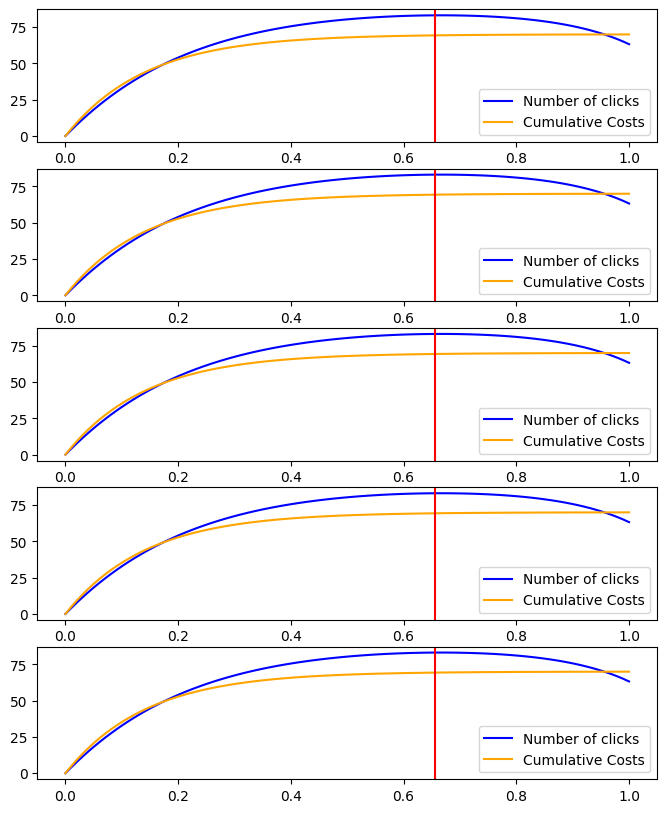

In [167]:
# advertising
n_bids = 100
min_bid = 0.0
max_bid = 1.0
bids = np.linspace(min_bid, max_bid, n_bids)
sigma_clicks = 3
sigma_costs = 3
def clicks(x):
  return 100 * (1.0 - np.exp(-4*x+3*x**3))
def costs(x):
  return 70 * (1.0 - np.exp(-7*x))
opt_bid = [bids[np.argmax(opt_rate[i]*prices[np.argmax(p[i,:]*prices)]*clicks(bids)-costs(bids))] for i in range(p.shape[0])]
fig, ax = plt.subplots(p.shape[0], figsize=(8,10))
for i in range(p.shape[0]):
  ax[i].plot(bids,clicks(bids),'blue',bids,costs(bids),'orange')
  ax[i].legend(["Number of clicks", "Cumulative Costs"])
  ax[i].axvline(opt_bid[i],c='red')
  print("Advertising (optimal bid):")
  print("idx: " + str(np.argmax(opt_rate[i]*prices[np.argmax(p[i,:]*prices)]*clicks(bids)-costs(bids))) + "  bid: " + str(opt_bid[i]) + "  clicks-costs: " + str(clicks(opt_bid[i])-costs(opt_bid[i])))

## Known advertising

In [168]:
# experiments
n_experiments = 10
change_frequency = 0.001

exp3_rewards_per_experiment = []
phase_tracker_per_experiment = []

for e in tqdm(range(0,n_experiments)):  # cycle on experiments
  env = Environment(n_arms = n_prices,
                    probabilities = p,
                    bids = bids,
                    average_number_of_clicks = clicks,
                    average_cum_daily_cost = costs,
                    noise_clicks = sigma_clicks,
                    noise_cost = sigma_costs,
                    change_frequency = change_frequency)
  exp3_learner = Exp3_Pricing_Learner(n_arms = n_prices,
                                      prices = prices,
                                      gamma=0.1)


  exp3_collected_costs = np.array([])
  exp3_daily_pricing_reward = np.array([])
  phase_tracker = np.array([])

  for t in range(0,T):  # cycle on time horizon

    # Exp3
    pulled_bid = np.argmax(clicks(bids)-costs(bids))
    reward_click, reward_cost = env.bidding_round(pulled_bid)
    exp3_collected_costs = np.append(exp3_collected_costs, reward_cost)
    for k in range(reward_click):
      pulled_price = exp3_learner.pull_arm()
      reward_price = env.pricing_round(pulled_price)
      exp3_learner.update(pulled_price, reward_price)

    exp3_daily_pricing_reward = np.append(exp3_daily_pricing_reward,(reward_click>0)*np.sum(exp3_learner.collected_rewards[-reward_click:]))

    phase_tracker = np.append(phase_tracker, env.i)

  exp3_rewards_per_experiment.append(exp3_daily_pricing_reward - exp3_collected_costs)
  phase_tracker_per_experiment.append(phase_tracker)

100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


In [169]:
opt=[]
for phase_tracker_ in phase_tracker_per_experiment:
  aux=np.array([])
  for phase in phase_tracker_:
    phase = int(phase)
    aux = np.append(aux,opt_rate[phase]*prices[np.argmax(p[phase]*prices)]*clicks(opt_bid[phase]) - costs(opt_bid[phase]))
  opt.append(aux)
opt=np.array(opt)
opt.shape

(10, 365)

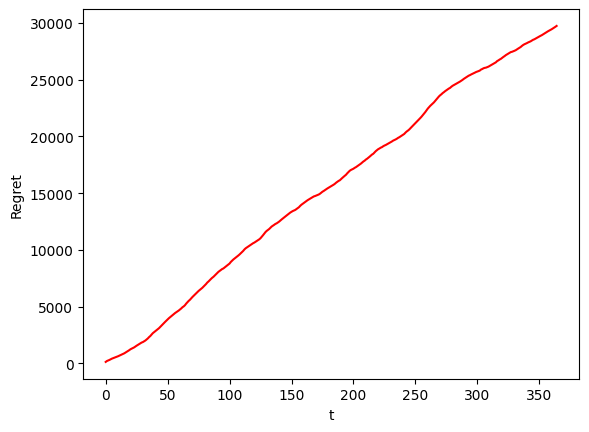

In [170]:
plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt - exp3_rewards_per_experiment, axis = 0)), 'r')